# Training a Convolutional Neural Network and Explaining its Predictions via Vanilla Gradient and LRP Methods (advanced)

The Net is trained on the CIFAR-10 dataset and explained its predictions in terms of input variables using Gradient$\,\times\,$Input, and LRP.

## Part 1: Training the Convolutional Network

To understand this code you need to understand the CIFAR-10 tutorial which is available at

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
torch.cuda.default_stream(device=0) 
import torchvision

Choosing the Cuda-GPU device on my PC, you can comment this step if no Cuda-GPU available

In [2]:
import torchvision.transforms as transforms
import utils
%matplotlib inline

First, the CIFAR-10 data is being loaded.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


We build a convolutional neural network composed of 4 layers parameters and two pooling stages. We also initialize objects used for optimization.

In [4]:
import torch.nn as nn
import torch.optim as optim

net = nn.Sequential(
    nn.Conv2d(  3, 16, 3), nn.ReLU(),
    nn.Conv2d( 16, 32, 3), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d( 32, 64, 5), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d( 64, 10, 5)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.95)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=20,   shuffle=True, num_workers=1)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=2000, shuffle=False, num_workers=1)

Now the Net is trainig on the data. Training up to a high accuracy can take a long time, especially if the code runs on the CPU. Here, for the purpose of this demonstration, we train the network only for 3 epochs, which leads to an accuracy around 69%. If you prefer, you could also train the network for longer (e.g. 5 or 10 epochs). This should as a result significantly improve accuracy.

In [5]:
for epoch in range(3):

    print('Epoch %d'%(epoch+1))
    
    for i,(xr,tr) in enumerate(trainloader):

        optimizer.zero_grad()
        yr = net(xr).view(-1,10)
        criterion(yr,tr).backward()
        optimizer.step()

        if i % 500 == 499:

            xt,tt = iter(testloader).next()
            yt = net(xt).view(-1,10)
            pt = torch.max(yt.data,dim=1)[1]
            acc = torch.mean((pt == tt).type(torch.FloatTensor)).item()
            print('%5d accuracy: %.3f' %(i+1,acc))

print('Finished Training')

Epoch 1
  500 accuracy: 0.405
 1000 accuracy: 0.507
 1500 accuracy: 0.522
 2000 accuracy: 0.558
 2500 accuracy: 0.615
Epoch 2
  500 accuracy: 0.628
 1000 accuracy: 0.632
 1500 accuracy: 0.656
 2000 accuracy: 0.683
 2500 accuracy: 0.670
Epoch 3
  500 accuracy: 0.692
 1000 accuracy: 0.661
 1500 accuracy: 0.674
 2000 accuracy: 0.688
 2500 accuracy: 0.696
Finished Training


## Part 2: Explaining the Model's Predictions

Once the model has been learned, we would like to explore in more detail which input features the model uses to support the evidence it has found for the correct class. To test the different explanation methods, we will consider a small subset of 15 data points from the test set.

In [6]:
visloader  = torch.utils.data.DataLoader(testset,  batch_size=15, shuffle=False, num_workers=1)
images, labels = iter(visloader).next()

### Gradient$\,\times\,$Input

Gradient$\,\times\,$Input explains based on the simple gradient computation $\mathrm{GI} = \nabla_{x} f_c(x) \odot x$. Here $c$ is the true class associated to the data point $x$. To visualize the explanation as a two-dimensional heatmap, obtained scores should furthermore be summed over the three color channels.

We implement Gradient$\,\times\,$Input and apply it to the dataset above.

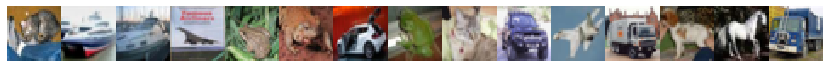

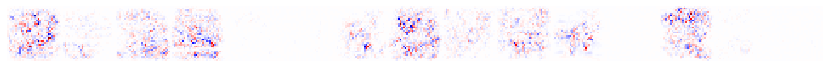

In [7]:
ximages = images.requires_grad_(True)
ypredimages = net(ximages).squeeze()
criterion(ypredimages,labels)
criterion(ypredimages,labels).backward()
dlossdx = ximages.grad
GI = (dlossdx*ximages).sum(dim=1)
utils.render(images.data.numpy())
utils.render(GI.data.numpy())

Altough capturing fine features in the data, the explanations are also relatively noisy and hard to interpret for a human.

### Layer-Wise Relevance Propagation

Layer-Wise Relevance Propagation (LRP) is an another method for explanation that operates by backward-propagating the prediction in the network by means of local redistribution rules. A simple recursive implementation of LRP that applies the rule
$R_i = \sum_j \frac{a_i w_{ij}}{\sum_i a_i w_{ij} + b_j} R_j$
at each layer is given below:

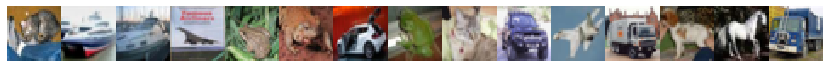

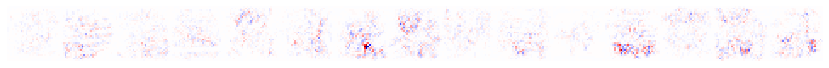

In [8]:
def lrp(A,layers,T,i=0):

    if len(layers) == 0:
        R = A*0
        for i,t in enumerate(T): R[i,t] = A[i,t]
        return R

    else:
        layer = layers[0]
        R = lrp(layer.forward(A),layers[1:],T,i=i+1)
        
        A = A.clone().detach().requires_grad_(True)
        Z = layer.forward(A)+1e-9
        Z = layer.forward(A)+1e-9
        (Z*(R/Z).data).sum().backward()
        R = A*A.grad
        return R
    

LRP = lrp(images,list(net),labels).sum(dim=1)

utils.render(images.data.numpy())
utils.render(LRP.data.numpy())